In [4]:
import os, sys, re
from itertools import islice 
import numpy as np
import pandas as pd
import hashlib
import random
import math
import json
from tqdm import tqdm
import IPython
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt

In [2]:
#keywords = ['people', 'something', 'little', 'hundred', 'important', 'problem', 'million', 
#            'technology', 'africa', 'science', 'community', 'government', 'challenge', 'major', 
#            'organization', 'london', 'washington', 'japanese', 'nigeria', 'england', 'germany',
#            'ingredients', 'rose', 'benjamin', 'kevin']

In [5]:
keywords = ['problem']

In [84]:
non_keywords = ['outside', 'different', 'information', 'service', 
                'seen', 'everything', 'collection', 'courses', 'insurance', 'issue', 
                'bank', 'continue', 'specific', 'best', 'watch', 'report', 'cost','back', 'was', 'here', 'their', 'will', 'went', 'have', 'what', 'which', 'with']

In [85]:
path = os.path.abspath("../../Datasets/TEDLIUM_release1/idiap_kw_db/")
filenames = []

for w in (keywords + non_keywords):
    current_path = os.path.join(path, w[0], w) 
    for _, _, files in os.walk(current_path):
        for file in files:
            filenames.append(os.path.join(current_path, file))

In [86]:
len(filenames)

44466

In [87]:
filenames[-1]

'/aimlx/Datasets/TEDLIUM_release1/idiap_kw_db/w/with/RichardDawkins_2002_5.wav'

In [88]:
def compute_mfcc(signal, num_features=40, nb_frames=98): 

    features = mfcc(signal, samplerate=16000, winlen=0.030, winstep=0.01, numcep=num_features, 
                         lowfreq=20, highfreq=4000, appendEnergy=False, nfilt=num_features)
    
    if features.shape[0] < nb_frames:
        zeros = np.zeros((nb_frames - features.shape[0], num_features))
        features = np.concatenate((features, zeros), axis=0)
    else:
        features = features[:nb_frames,:]
    
    return features

In [89]:
count = {}
for file in tqdm(filenames):
    _, signal = wav.read(file)
    features = mfcc(signal, samplerate=16000, winlen=0.030, winstep=0.01, numcep=40, 
                         lowfreq=20, highfreq=4000, appendEnergy=False, nfilt=40)
    if features.shape[0] in count.keys():
        count[features.shape[0]] += 1
    else:
        count[features.shape[0]] = 1

100%|██████████| 44466/44466 [01:01<00:00, 722.04it/s]


<Container object of 101 artists>

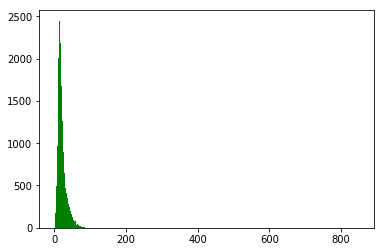

In [90]:
plt.bar(count.keys(), count.values(), 1.0, color='g')

In [91]:
kw = filenames[0].split('/')[-2]
base_name = kw + '-' + os.path.basename(filenames[0]).replace('_', '-', 1)
hash_name = re.sub(r'_.*$', '', base_name).encode('utf-8')

In [92]:
hash_name

b'problem-DavidBlaine-2009P'

In [93]:
MAX_NUM_WAVS_PER_CLASS = 2**27 - 1  # ~134M

def which_set(filename, validation_percentage, testing_percentage):
    """
    Determines which data partition the file should belong to.

    We want to keep files in the same training, validation, or testing sets even
    if new ones are added over time. This makes it less likely that testing
    samples will accidentally be reused in training when long runs are restarted
    for example. To keep this stability, a hash of the filename is taken and used
    to determine which set it should belong to. This determination only depends on
    the name and the set proportions, so it won't change as other files are added.

    It's also useful to associate particular files as related (for example words
    spoken by the same person), so anything after '_.' in a filename is
    ignored for set determination. This ensures that 'AdamSavage_2008P_5.wav' and
    'AdamSavage_2008P_0.wav' are always in the same set, for example.

    Args:
    filename: File path of the data sample.
    validation_percentage: How much of the data set to use for validation.
    testing_percentage: How much of the data set to use for testing.

    Returns:
    String, one of 'training', 'validation', or 'testing'.
    """
    
    kw = filename.split('/')[-2]
    base_name = kw + '-' + os.path.basename(filename).replace('_', '-', 1)
    # We want to ignore anything after '-' in the file name when
    # deciding which set to put a wav in, so the data set creator has a way of
    # grouping wavs that are close variations of each other.
    hash_name = re.sub(r'_.*$', '', base_name).encode('utf-8')
    # This looks a bit magical, but we need to decide whether this file should
    # go into the training, testing, or validation sets, and we want to keep
    # existing files in the same set even if more files are subsequently
    # added.
    # To do that, we need a stable way of deciding based on just the file name
    # itself, so we do a hash of that and then use that to generate a
    # probability value that we use to assign it.
    hash_name_hashed = hashlib.sha1(hash_name).hexdigest()
    percentage_hash = ((int(hash_name_hashed, 16) %
                      (MAX_NUM_WAVS_PER_CLASS + 1)) *
                     (100.0 / MAX_NUM_WAVS_PER_CLASS))
    if percentage_hash < validation_percentage:
        result = 'validation'
    elif percentage_hash < (testing_percentage + validation_percentage):
        result = 'testing'
    else:
        result = 'training'
    return result

In [94]:
def generate_sets(filenames, validation_percentage=10, testing_percentage=10):
    '''
    each data sample in the tuple (features, label)
    '''
    
    non_keywords_label = len(keywords)

    training, validation, testing = [], [], []

    for filename in tqdm(filenames):
        _, signal = wav.read(filename)
        feats = compute_mfcc(signal)
                    
        kw = filename.split('/')[-2]
        
        if kw in keywords:
            label = keywords.index(kw)
        else:
            label = non_keywords_label
            
        grp = which_set(filename, validation_percentage, testing_percentage)
        
        if grp is 'training':
            training.append((feats, label))
        elif grp is 'validation':
            validation.append((feats, label))
        else:
            testing.append((feats, label))
    
    return training, validation, testing

In [95]:
training, validation, testing = generate_sets(filenames, validation_percentage=10, testing_percentage=10)

100%|██████████| 44466/44466 [01:00<00:00, 736.12it/s]


In [96]:
def get_X_y(grp):
    X, y = zip(*grp)
    X = list(map(lambda x: x.reshape(98, 40, 1), X))
    return np.array(X).reshape(-1, 98, 40, 1), np.array(y).reshape(-1,1)

In [97]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, AveragePooling2D, Dense, Flatten, Input, Add, Lambda
from keras.utils import to_categorical
from keras.models import Model
from sklearn.metrics import accuracy_score

In [98]:
def res_net():
    
    input_data = Input(shape=(98,40,1))
    l = 0
    for i in range(6):
        if i == 0:
            x = Conv2D(7, kernel_size=(3,3), activation='relu', data_format='channels_last', 
                       padding='same', kernel_initializer='glorot_uniform')(input_data)
            x = BatchNormalization(axis=-1)(x)
            l += 1
            x = Conv2D(7, kernel_size=(3,3), activation='relu', data_format='channels_last', 
                       padding='same', kernel_initializer='glorot_uniform', dilation_rate=int(math.pow(2, np.floor(l/3))))(x)
            l += 1
            x = BatchNormalization(axis=-1)(x)
        else:
            y = Conv2D(7, kernel_size=(3,3), activation='relu', data_format='channels_last', 
                       padding='same', kernel_initializer='glorot_uniform', dilation_rate=int(math.pow(2, np.floor(l/3))))(x)
            y = BatchNormalization(axis=-1)(y)
            l += 1
            y = Conv2D(7, kernel_size=(3,3), activation='relu', data_format='channels_last', 
                       padding='same', kernel_initializer='glorot_uniform', dilation_rate=int(math.pow(2, np.floor(l/3))))(y)
            l += 1
            y = BatchNormalization(axis=-1)(y)

            y = Add()([y, x])
            x = Lambda(lambda x: x)(y)
    
    x = AveragePooling2D(pool_size=(2,2),data_format='channels_last')(x)
    x = Flatten()(x)
    x = Dense(units=len(keywords) + 1, activation='softmax')(x)
    
    model = Model(inputs=input_data, outputs=x) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

def dnn_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5,5), activation='relu', input_shape=(98, 40, 1), data_format='channels_last')) 
    model.add(BatchNormalization(axis=-1))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, kernel_size=(5,5), activation='relu')) 
    model.add(BatchNormalization(axis=-1))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, kernel_size=(5,5), activation='relu')) 
    model.add(BatchNormalization(axis=-1))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=len(keywords) + 1, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [99]:
X_train, y_train = get_X_y(training)
X_validation, y_validation = get_X_y(validation)
y_train, y_validation = to_categorical(y_train), to_categorical(y_validation)

In [100]:
model = dnn_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 94, 36, 32)        832       
_________________________________________________________________
batch_normalization_10 (Batc (None, 94, 36, 32)        128       
_________________________________________________________________
average_pooling2d_10 (Averag (None, 47, 18, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 43, 14, 64)        51264     
_________________________________________________________________
batch_normalization_11 (Batc (None, 43, 14, 64)        256       
_________________________________________________________________
average_pooling2d_11 (Averag (None, 21, 7, 64)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 17, 3, 128)        204928    
__________

In [101]:
model.fit(X_train, y_train, batch_size=20, epochs=4, verbose=1, validation_data=(X_validation, y_validation))

Train on 35686 samples, validate on 4369 samples
Epoch 1/4
35686/35686 [==============================] - 101s 3ms/step - loss: 0.0424 - acc: 0.9874 - val_loss: 0.0572 - val_acc: 0.9803
Epoch 2/4
35686/35686 [==============================] - 100s 3ms/step - loss: 0.0190 - acc: 0.9943 - val_loss: 0.0184 - val_acc: 0.9940
Epoch 3/4
35686/35686 [==============================] - 101s 3ms/step - loss: 0.0122 - acc: 0.9966 - val_loss: 0.0758 - val_acc: 0.9789
Epoch 4/4
35686/35686 [==============================] - 101s 3ms/step - loss: 0.0097 - acc: 0.9973 - val_loss: 0.0051 - val_acc: 0.9991


In [102]:
X_test, y_test = get_X_y(testing)
y_pred = model.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred, axis=1).reshape(-1,1)

4411/4411 [==============================] - 3s 583us/step


In [103]:
def accuracy_per_label(y_true, y_pred, label):
    y_true_label = y_true[y_true == label]
    y_pred = y_pred[y_true == label]
    n_samples = len(y_pred)
    return n_samples, accuracy_score(y_true_label, y_pred)

In [104]:
accuracies_per_label = []

for i in range(len(keywords) + 1):
    n, acc = accuracy_per_label(y_test, y_pred, label=i)
    if i < len(keywords):
        accuracies_per_label.append((n, acc, keywords[i]))
    else:
        accuracies_per_label.append((n, acc, 'non_keyword'))

In [105]:
accuracies_per_label = sorted(accuracies_per_label, key=lambda x: x[0], reverse=True)
accuracies_per_label

[(4321, 0.9997685720897941, 'non_keyword'), (90, 0.9, 'problem')]

In [220]:
def generates_frames(features, shift=5, frame_length=98, num_mffc=40):
    frames = []
    window_size = features.shape[0]
    enough_samples = True
    current_index = 0
    
    while enough_samples:
        if current_index + frame_length < window_size:
            frames.append(features[current_index: current_index + frame_length, :])
            current_index += shift
        else:
            frames.append(features[-frame_length:,:])
            enough_samples = False
    return np.array(frames).reshape(-1, frame_length, num_mffc, 1)

def compute_mfcc_frames(signal, shape=(98,40)):
    features = mfcc(signal, samplerate=16000, winlen=0.030, winstep=0.01, numcep=shape[1], 
                         lowfreq=20, highfreq=4000, appendEnergy=False, nfilt=shape[1])
    print(features.shape)
    if features.shape[0] <= shape[0]:
        nb_samples = shape[0] - features.shape[0]
        features = np.concatenate((np.zeros((nb_samples, shape[1])), features), axis=0)
        return features.reshape(1, shape[0], shape[1], 1)
    else:
        frames = generates_frames(features, shift=4, frame_length=shape[0], num_mffc=shape[1])
        return frames

In [163]:
def create_file(path2dataset='/aimlx/Datasets/TEDLIUM_release1/'):
    file_partition = []
    
    current_path = os.path.join(path2dataset, 'dev', 'wav')
    for _, _, files in os.walk(current_path):
        for file in files:
            file_partition.append(('dev',  os.path.join(current_path,file)))

    current_path = os.path.join(path2dataset, 'test', 'wav')
    for _, _, files in os.walk(current_path):
        for file in files:
            file_partition.append(('test',  os.path.join(current_path,file)))

    current_path = os.path.join(path2dataset, 'train', 'wav')
    for _, _, files in os.walk(current_path):
        for file in files:
            file_partition.append(('train', os.path.join(current_path,file)))                

    #pickle.dump(file_partition, fp)
    return file_partition

In [164]:
def extract_sentence(path2wav_file, path2dataset, duration=5):
    file_partition = create_file()
    filename = path2wav_file.split('/')[-1]
    occurence = int(filename.split('_')[-1].split('.')[0])
    filename = '_'.join(filename.split('_')[:2])
    keyword = path2wav_file.split('/')[-2]
    
    filtered_list = list(filter(lambda x: filename in x[1], file_partition))[0]
    partition = filtered_list[0]
    path2wav_talk = filtered_list[1]
        
    path2json = os.path.join(path2dataset, partition, 'final_json', filename + '.json')
    with open(path2json) as json_file:
        data = json.load(json_file)
        count = -1 
        for word in data['words']:
            if partition == 'train':
                word = data['words'][word]
            if not word['case'] == 'not-found-in-audio' and (word['alignedWord'] == keyword):
                count += 1
            if count == occurence:
                start_kw, end_kw = word['start'], word['end']
                break
                
    if start_kw - duration/2.0 < 0:
        start_sentence = 0
        end_sentence = duration - end_kw
    else:
        start_sentence = start_kw - duration/2.0
        end_sentence = end_kw + duration/2.0
        
    fs, signal = wav.read(path2wav_talk)
    start_signal, end_signal = int(start_sentence * fs), int(end_sentence * fs)
    
    return fs, signal[start_signal:end_signal]

In [165]:
test_files = []
for file in filenames:
    grp = which_set(file, validation_percentage=10, testing_percentage=10)
    if grp is 'testing':
        test_files.append(file)

In [166]:
test_files_iterator = iter(test_files)

In [228]:
fs, sentence = extract_sentence(path2wav_file=next(test_files_iterator), path2dataset='/aimlx/Datasets/TEDLIUM_release1/')
IPython.display.Audio(sentence, rate=fs)

In [227]:
frames = compute_mfcc_frames(sentence)
y_pred = model.predict(frames, verbose=1)
y_pred = np.argmax(y_pred, axis=1)
y_pred

(559, 40)
117/117 [==============================] - 0s 833us/step


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])

In [189]:
fs, sig = wav.read('/aimlx/Datasets/TEDLIUM_release1/kw_db/organization/CharlesLeadbeater_2005G-1.wav')
frames = compute_mfcc_frames(sig)

(77, 40)


In [208]:
y_pred = model.predict(frames, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

1/1 [==============================] - 0s 4ms/step


In [209]:
y_pred

array([14])

In [37]:
l = iter([1, 2, 6])